In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [87]:
class Magnet:
    def __init__(self, position, momentum):
        self.position = np.array(position)
        self.momentum = np.array(momentum)
        
    def get_potential(self, theta, mu0=1, l=1):
        theta = theta % (2 * np.pi)
        pendulum_direction = np.array([np.sin(theta), np.cos(theta)])
        pendulum_momentum = pendulum_direction
        pendulum_position = l * pendulum_direction
        # print(pendulum_direction, pendulum_momentum, pendulum_position, self.momentum)
        
        r = pendulum_position - self.position
        r_norm = np.linalg.norm(r)
        
        return -mu0 / (4 * np.pi) * ( np.dot(self.momentum, pendulum_momentum) - 3 * np.dot(self.momentum, r) * np.dot(pendulum_momentum, r) ) / (r_norm**5)
    
    def get_potential_derivative(self, theta, mu0=1, dtheta=1e-5, l=1):
        val0 = self.get_potential(theta - dtheta, mu0=mu0, l=l)
        val1 = self.get_potential(theta + dtheta, mu0=mu0, l=l)
        
        return (val1 - val0) / (2 * dtheta)

class System:
    def __init__(self, ic=[0, 0], damp=0.2, moment=1, mu0=1, length=1, dt=0.1, t_max=100):
        self.angle = ic[0]
        self.velocity = ic[1]
        self.damp = damp
        self.moment = moment
        self.mu0 = mu0
        self.length = length
        self.dt = dt
        self.t_max = t_max
        
        self.magnets = []
        self.angle_list = []
        self.velocity_list = []
        
    def add_magnet(self, magnet):
        self.magnets.append(magnet)
        
    def rhs(self, ic):
        g = 1
        l = self.length
        
        dL = -g / l * np.sin(ic[0]) - self.damp * ic[1]
        
        for magnet in self.magnets:
            dL += -magnet.get_potential(ic[0], l, self.mu0)
        
        return np.array([ic[1], dL])
        
    def rk4_step(self, ic):
        k1 = self.rhs(ic)
        k2 = self.rhs(ic + self.dt / 2 * k1)
        k3 = self.rhs(ic + self.dt / 2 * k2)
        k4 = self.rhs(ic + self.dt * k3)
        
        return ic + self.dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        
    def solve(self, save=True):
        num_steps = int(self.t_max / self.dt)
        
        vals = []
        vals.append(np.array([self.angle, self.velocity]))
        
        for _ in range(num_steps - 1):
            vals.append(self.rk4_step(vals[-1]))
        
        vals = np.array(vals)
        
        if save:
            np.save("angle_list.npy", vals[:, 0])
            np.save("velocity_list.npy", vals[:, 1])
            magnets = np.array([np.concatenate([magnet.position, magnet.momentum]) for magnet in self.magnets])
            np.save("magnets.npy", magnets)
        
        self.angle_list = vals[:, 0]
        self.velocity_list = vals[:, 1]
    
    def plot_solution(self, ax=None, color=None):
        if ax is None:
            fig, ax = plt.subplots()
            
        ax.set_title("Solution")
        ax.set_xlabel("Time")
        ax.set_ylabel("Angle")
        
        plt.plot(np.linspace(0, self.t_max, len(self.angle_list)), self.angle_list)
    
    def get_critical_points(self):
        def f(initial_angle):
            m = 1
            g = 1
            l = self.length
            mu0 = 1
            
            dL = -g / l * np.sin(initial_angle[0])
            
            for magnet in self.magnets:
                dL += -mu0 / (4 * np.pi) * magnet.get_potential(initial_angle[0], l)
            
            return dL
        
        critical_points = []
        initial_angles = np.linspace(0, 2 * np.pi, 100, endpoint=False)
        
        for angle in initial_angles:
            new_cp = fsolve(f, angle)[0] % (2 * np.pi)
            # new_cp = fsolve(self.rhs, [angle, 0])[0] % (2 * np.pi)
            is_new = True
            for cp in critical_points:
                if np.abs(cp - new_cp) < 1e-3:
                    is_new = False
                    break
            if is_new:
                critical_points.append(new_cp)
            
        
        critical_points = np.array(critical_points)
        np.save("equil_points.npy", critical_points)
        
        
        return critical_points
    
    

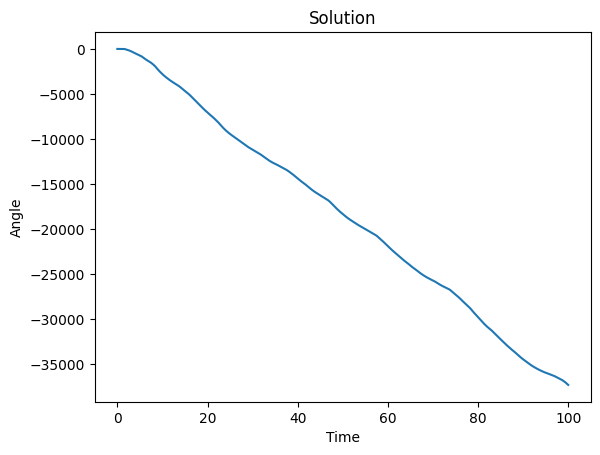

In [89]:
marcus = System(ic=[-1, 0])
marcus.add_magnet(Magnet([0, 1.2], [0, -10]))
marcus.solve()
marcus.plot_solution()
plt.show()
crit_points = marcus.get_critical_points()
# print(crit_points)